## Plan
1. Clean data (if necessary)
2. Put data into a suitable data structure
3. Train models

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [6]:
ruta_raiz = os.path.dirname(os.getcwd()) 
ruta_csv = os.path.join(ruta_raiz, "data", "home-credit-default-risk", "application_train.csv")
data = pd.read_csv(ruta_csv)

In [7]:
print(data.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

The first thing I will do is to create new variables that will better suit the models.

In [8]:
data = data.assign(
    AGE = abs(data['DAYS_BIRTH']) / 365,
    YEARS_EMPLOYED = abs(data['DAYS_EMPLOYED']) / 365,
    INCOME_PER_CHILD = data['AMT_INCOME_TOTAL'] / (data['CNT_CHILDREN'] + 1),
    PAYMENT_RATE = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL'],
    CREDIT_GOODS_RATIO = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE'],
    CREDIT_DOWNPAYMENT = data['AMT_GOODS_PRICE'] - data['AMT_CREDIT']
)

C:\Users\andre\AppData\Local\Temp\ipykernel_6156\2725410066.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data = data.assign(


Payment rate tells me the percentage of the borrowers monthly income that each payment represents.

In [9]:
correlations = data.corr(numeric_only=True)['TARGET'].sort_values()

print("\nFeatures with the highest negative correlation (reduce risk)")
print(correlations.head(15))


print("\nFeautres with the highest positive correlation (increase risk)")
print(correlations.tail(15))


Features with the highest negative correlation (reduce risk)
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
AGE                          -0.078239
YEARS_EMPLOYED               -0.047046
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
CREDIT_DOWNPAYMENT           -0.034254
ELEVATORS_AVG                -0.034199
ELEVATORS_MEDI               -0.033863
FLOORSMIN_AVG                -0.033614
Name: TARGET, dtype: float64

Feautres with the highest positive correlation (increase risk)
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE      

In [10]:
def plot_distribution(df, column, title):
    plt.figure(figsize=(10,6))
    sns.histplot(df[column].dropna(), kde=True, color='green')
    plt.title(title)
    plt.show()

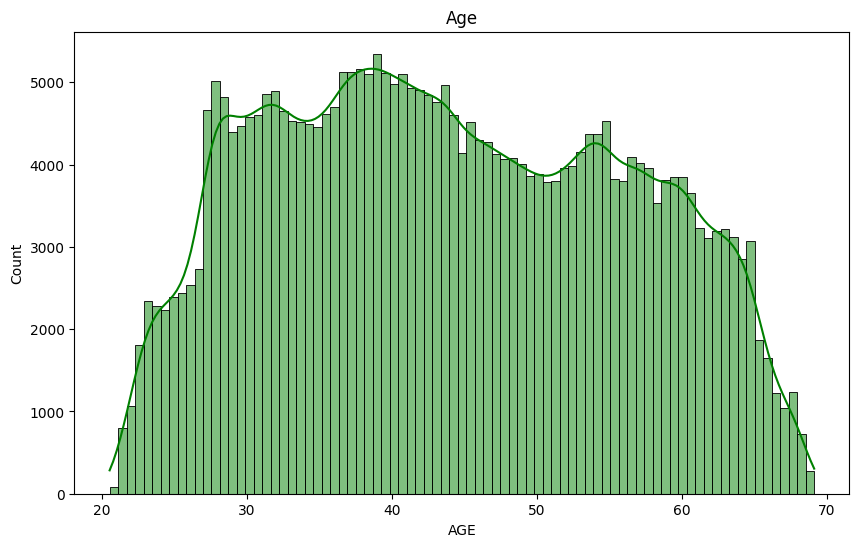

In [11]:
plot_distribution(data, "AGE", "Age")

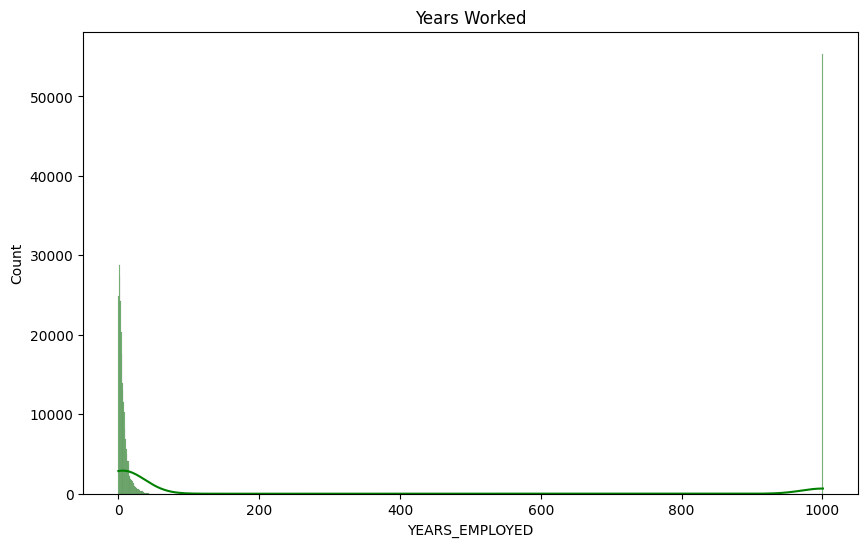

In [12]:
plot_distribution(data, "YEARS_EMPLOYED", "Years Worked")

It looks like the dataset uses the number 365243 as a way to show a borrower is unemployed. I will use this to create a new variable that informs wether a borrower is unemployed.

In [13]:
data["IS_EMPLOYED"] = (data["DAYS_EMPLOYED"] != 365243).astype(int)
data["DAYS_EMPLOYED_CLEAN"] = data["DAYS_EMPLOYED"].replace(365243, 0)
data["YEARS_EMPLOYED_CLEAN"] = abs(data["DAYS_EMPLOYED_CLEAN"]) / 365

C:\Users\andre\AppData\Local\Temp\ipykernel_6156\590873813.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["IS_EMPLOYED"] = (data["DAYS_EMPLOYED"] != 365243).astype(int)
C:\Users\andre\AppData\Local\Temp\ipykernel_6156\590873813.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["DAYS_EMPLOYED_CLEAN"] = data["DAYS_EMPLOYED"].replace(365243, 0)
C:\Users\andre\AppData\Local\Temp\ipykernel_6156\590873813.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

I had a choice to either fill the 365243 with either 0's or with the Median value. The problem with filling it with the median value is those unemployed entries would be interpreted as 4-5 years of experience, which is clearly false.

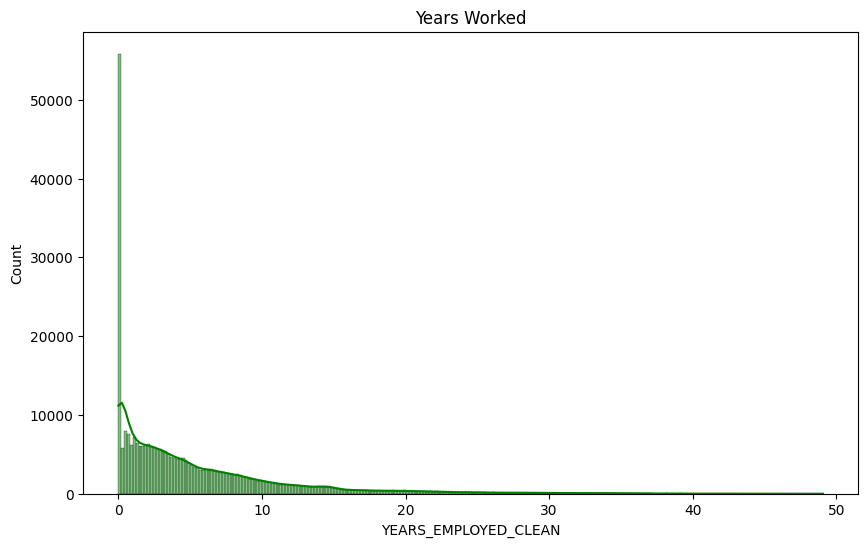

In [14]:
plot_distribution(data, "YEARS_EMPLOYED_CLEAN", "Years Worked")

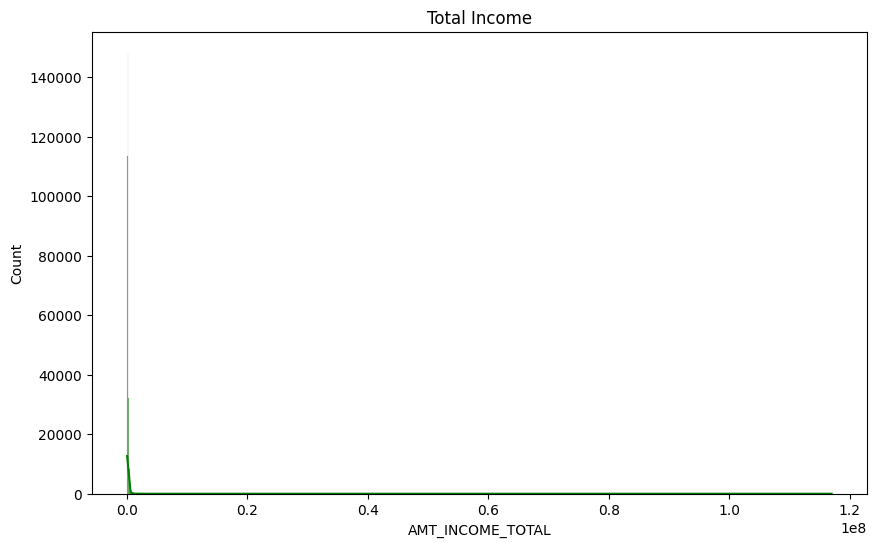

In [15]:
plot_distribution(data, "AMT_INCOME_TOTAL", "Total Income")


To see the Income data properly, I will filter some of the highest income entries that skews the graph.

In [16]:
print(data['AMT_INCOME_TOTAL'].sort_values(ascending=False).head(10))

12840     117000000.0
203693     18000090.0
246858     13500000.0
77768       9000000.0
131127      6750000.0
103006      4500000.0
287463      4500000.0
187833      4500000.0
204564      4500000.0
181698      3950059.5
Name: AMT_INCOME_TOTAL, dtype: float64


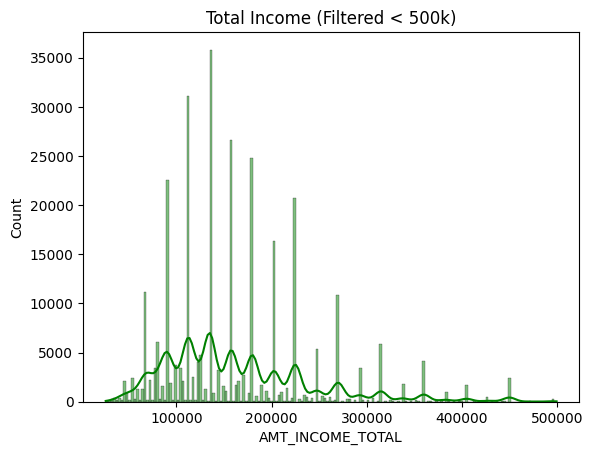

In [17]:
sns.histplot(data[data['AMT_INCOME_TOTAL'] < 500000]['AMT_INCOME_TOTAL'], kde=True, color='green')
plt.title('Total Income (Filtered < 500k)')
plt.show()

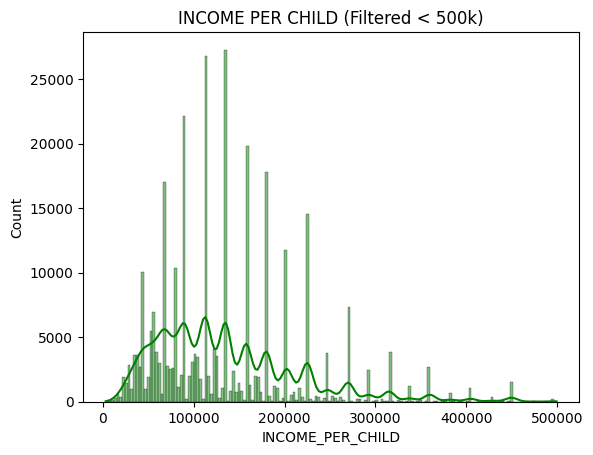

In [18]:
sns.histplot(data[data["AMT_INCOME_TOTAL"] < 500000]["INCOME_PER_CHILD"], kde=True, color='green')
plt.title('INCOME PER CHILD (Filtered < 500k)')
plt.show()

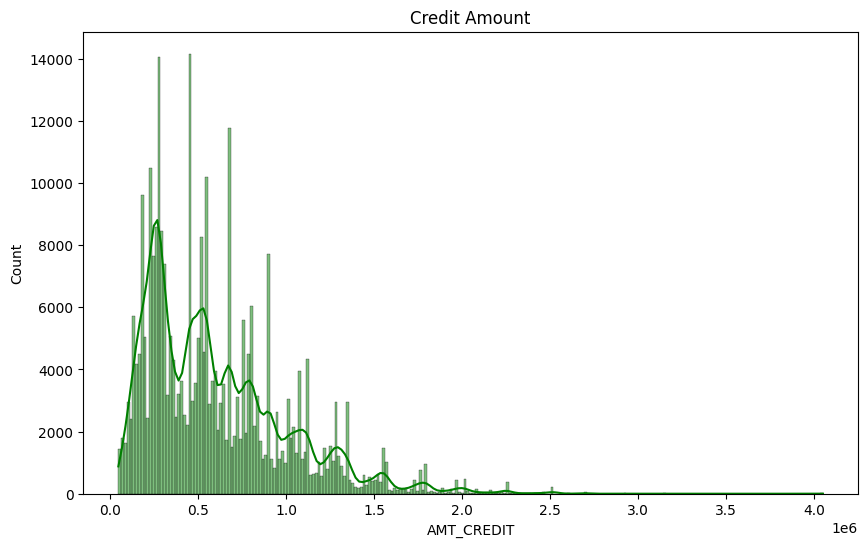

In [19]:
plot_distribution(data, "AMT_CREDIT", "Credit Amount")

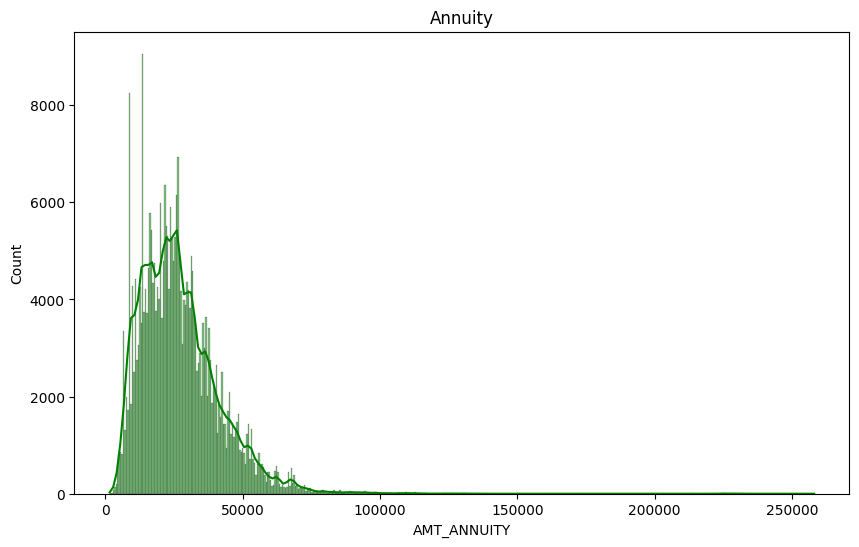

In [20]:
plot_distribution(data, "AMT_ANNUITY", "Annuity")

## Structure Data


In [31]:
cols_to_use = [
    'AMT_CREDIT', 'AMT_ANNUITY', 'AGE', 'YEARS_EMPLOYED_CLEAN', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'INCOME_PER_CHILD', 'PAYMENT_RATE', 'REGION_RATING_CLIENT', 'CREDIT_GOODS_RATIO', 'CREDIT_DOWNPAYMENT'
]

X = data[cols_to_use]
y = data["TARGET"]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import SimpleImputer

# columns which I decided to fill with the median
cols_to_fill = [
    'AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'INCOME_PER_CHILD', 'AMT_ANNUITY', 'REGION_RATING_CLIENT', 'PAYMENT_RATE',
    'CREDIT_GOODS_RATIO', 'CREDIT_DOWNPAYMENT'

]

imputer = SimpleImputer(strategy='median')

X_train[cols_to_fill] = imputer.fit_transform(X_train[cols_to_fill])
X_test[cols_to_fill] = imputer.transform(X_test[cols_to_fill])

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train the Model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(class_weight='balanced', max_iter=1000)


model.fit(X_train_scaled, y_train)

predictions_LR = model.predict(X_test_scaled)

precision = accuracy_score(y_test, predictions_LR)

print(precision)

0.6736744549046388


In [26]:
from sklearn.metrics import confusion_matrix

def build_CM(y_test, predictions):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title('Confusion Matrix (Balanced Model)')
    plt.ylabel('Value')
    plt.xlabel('Prediction')
    plt.show()

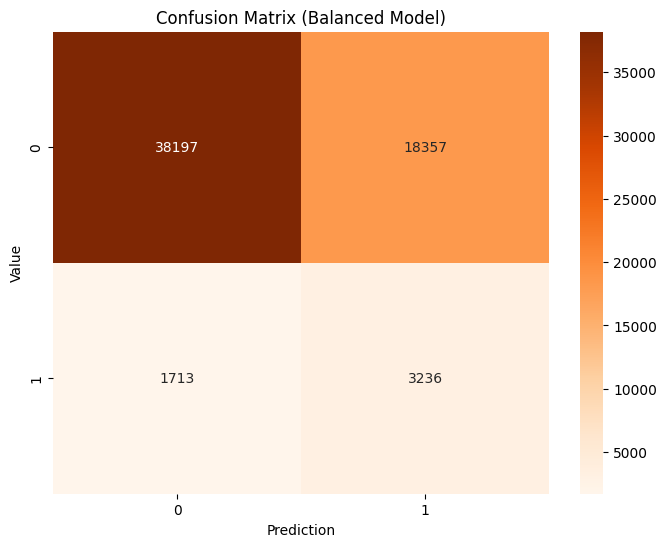

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56554
           1       0.15      0.65      0.24      4949

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.67      0.75     61503



In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

build_CM(y_test, predictions_LR)

print(classification_report(y_test, predictions_LR))

I am using recall to measure the model's performance because I think it is more important to minimize false negatives rather than maximize overall accuracy.

After fine tuning the variables inputted into the model, I have come to the conclusion that the logistic regression model's recall tops out at around 0.65.


### Random Forest


In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

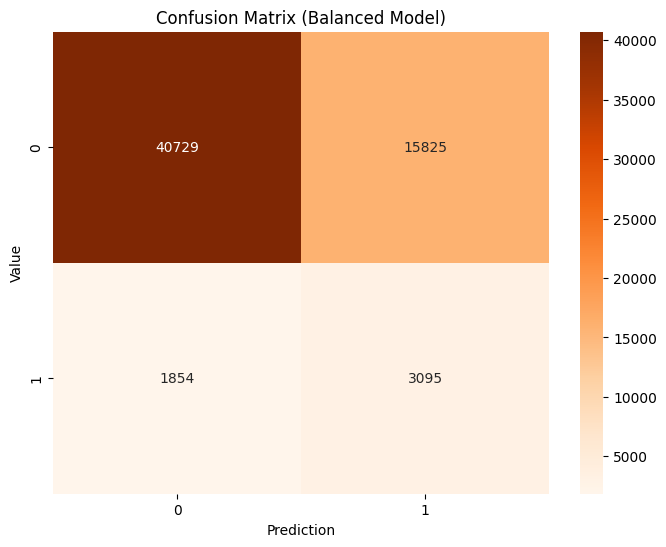

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56554
           1       0.16      0.63      0.26      4949

    accuracy                           0.71     61503
   macro avg       0.56      0.67      0.54     61503
weighted avg       0.89      0.71      0.78     61503



In [30]:
predictions_rf = rf_model.predict(X_test_scaled)

build_CM(y_test, predictions_rf)

print(classification_report(y_test, predictions_rf))

Very similar result to logistic regression.